# Thesis ADS: Rosa Lucassen

## Loading the data

In [1]:
import pandas as pd
import numpy as np
import pickle
import spacy
nlp = spacy.load("en_core_web_sm")
import re
from collections import Counter
import emoji
import stop_words
from scipy.stats import chi2_contingency
from urllib.parse import urlparse
from nltk.stem.porter import PorterStemmer
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet

import numpy as np
import logging
import pyLDAvis.gensim
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

import gensim

from gensim.models import Phrases

stemmer = PorterStemmer()

d_test = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Test.xlsx")
d_train = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Train.xlsx")
d_val = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/Constraint_English_Val.xlsx")
d_test_labeled = pd.read_excel("/Users/rosalucassen/Desktop/Thesis/Code/Data/english_test_with_labels.xlsx")

## Function: Cleaning data

In [2]:
def remove_single_char(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

def remove_numbers(text):
    number_pattern = r'\b(?<![0-9-])(\d+)(?![0-9-])'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number


def remove_urls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    without_urls = re.sub(pattern=url_pattern, repl=" ", string=text)
    return without_urls


def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    without_emoji = emoji_pattern.sub(r'',text)
    return without_emoji

def remove_nonalpha(text):
    nonalpha_pattern = "[+$@#?~]"
    without_nonalpha = re.sub(pattern=nonalpha_pattern, repl=" ", string=text)
    return without_nonalpha
    
def remove_rt(text):
    rt_pattern = 'rt @[\w_]+: '
    without_pattern = re.sub(pattern = rt_pattern, repl=" ", string = text)
    return without_pattern 

def remove_extra_spaces(text):
    space_pattern = r'\s+'
    without_space = re.sub(pattern=space_pattern, repl=" ", string=text)
    return without_space


## Function BiGrams

In [3]:
from gensim.models import Phrases
def make_n_grams(docs):
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=20)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    return docs

## Function: Lemmatizing texts

In [4]:
def pre_processer_real(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    #corpus = ' '.join(corpus).split()

    processed_texts = [text for text in nlp.pipe(corpus, 
                                              disable=["ner",
                                                       "parser"])]
    
    
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] 
                            for lemma_ in processed_texts]
    tokenized_texts = make_n_grams(tokenized_texts)
    
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    flat_real = flatten(tokenized_texts)
    counts = Counter(flat_real)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] * (10000) / total_words
    return counts.most_common()[:20], flat_real, tokenized_texts

def pre_processer_fake(corpus):
    corpus = [text.lower() for text in corpus]
    corpus = [remove_urls(text) for text in corpus]
    corpus = [remove_single_char(text) for text in corpus]
    corpus = [remove_numbers(text) for text in corpus]
    corpus = [remove_rt(text) for text in corpus]
    corpus = [remove_emojis(text) for text in corpus]
    corpus = [remove_nonalpha(text) for text in corpus]
    corpus = [text.encode("ascii", "ignore") for text in corpus]
    corpus = [text.decode() for text in corpus]
    corpus = [remove_extra_spaces(text) for text in corpus]
    #corpus = ' '.join(corpus).split()
    
    processed_texts = [text for text in nlp.pipe(corpus, 
                                              disable=["ner",
                                                       "parser"])]
    tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] 
                            for lemma_ in processed_texts]
    tokenized_texts = make_n_grams(tokenized_texts)
    
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    flat_fake = flatten(tokenized_texts)
    counts = Counter(flat_fake)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] * (10000) / total_words
    return counts.most_common()[:20], flat_fake, tokenized_texts

## Function: distinctive words

In [5]:
def distinctive_words(target_corpus, reference_corpus):
    counts_c1 = Counter(target_corpus) # don't forget to flatten your texts!
    counts_c2 = Counter(reference_corpus)
    vocabulary = set(list(counts_c1.keys()) + list(counts_c2.keys()))
    freq_c1_total = sum(counts_c1.values()) 
    freq_c2_total = sum(counts_c2.values()) 
    results = []
    for word in vocabulary:
        freq_c1 = counts_c1[word]
        freq_c2 = counts_c2[word]
        freq_c1_other = freq_c1_total - freq_c1
        freq_c2_other = freq_c2_total - freq_c2
        llr, p_value,_,_ = chi2_contingency([[freq_c1, freq_c2], 
                      [freq_c1_other, freq_c2_other]],
                      lambda_='log-likelihood') 
        if freq_c2 / freq_c2_other > freq_c1 / freq_c1_other:
            llr = -llr
        result = {'word':word, 
                    'llr':llr,
                    'p_value': p_value}
        results.append(result)
    results_df = pd.DataFrame(results)
    return results_df

## Function: Topic modelling LDA Gensim

In [6]:
def topic_modelling(tokenized_text, n_topics, n_iterations):
    results = []


    dictionary = Dictionary(tokenized_text) # get the vocabulary

    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'
    N_TOPICS = n_topics
    N_ITERATIONS = n_iterations

    lda = LdaMallet(PATH_TO_MALLET,
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=N_TOPICS,
                    iterations=N_ITERATIONS)

    for topic in range(N_TOPICS):
        words = lda.show_topic(topic, 10)
        topic_n_words = ' '.join([word[0] for word in words])
        result = {'Topic':str(topic), 
                    'Words':topic_n_words}
        results.append(result)
    results_df = pd.DataFrame(results)
    pd.set_option('display.max_colwidth', None)
    return results_df, lda, dictionary

In [7]:
def topic_modelling_results(tokenized_text, n_topics, n_iterations):
    results = []

    dictionary = Dictionary(tokenized_text) # get the vocabulary
    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'
    N_TOPICS = n_topics
    N_ITERATIONS = n_iterations

    lda = LdaMallet(PATH_TO_MALLET,
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=N_TOPICS,
                    iterations=N_ITERATIONS)
    
    for topic in range(N_TOPICS):
        words = lda.show_topic(topic)
        topic_n_words = ' '.join([word[0] for word in words])
        result = {'Topic':str(topic), 
                    'Words':topic_n_words}
        results.append(result)
    results_DF = pd.DataFrame(results)
    pd.set_option('display.max_colwidth', None)
    return results_DF, lda, dictionary

## Exploring the data

#### Training data

In [ ]:
d_train.info()

In [ ]:
d_train.head()

In [ ]:
d_train["label"].unique()

In [ ]:
grouped_train = d_train.groupby('label').count() 
grouped_train.head()

#### Validation data

In [ ]:
d_val.info()

In [ ]:
d_val.head()

In [ ]:
d_val["label"].unique()

In [ ]:
grouped_val = d_val.groupby('label').count() 
grouped_val.head()

### Test data

In [ ]:
d_test.info()

In [ ]:
d_test.head()

In [ ]:
d_test_labeled.info()

In [ ]:
d_test_labeled.head()

In [ ]:
d_test_labeled["label"].unique()

In [ ]:
grouped_test = d_test_labeled.groupby('label').count() 
grouped_test.head()

## Combine labelled data

In [8]:
data_train = pd.concat([d_train, d_val])
data_train.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8560 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8560 non-null   int64 
 1   tweet   8560 non-null   object
 2   label   8560 non-null   object
dtypes: int64(1), object(2)
memory usage: 267.5+ KB


In [9]:
grouped_train = data_train.groupby('label').count() 
grouped_train.head()

,id,tweet
label,,
fake,4080,4080
real,4480,4480


## Results: Pre-processing

In [9]:
corpus_train_fake = data_train[data_train.label == "fake"]["tweet"]
corpus_train_real = data_train[data_train.label == "real"]["tweet"]
output_fake, flat_fake, tokenized_texts_fake = pre_processer_fake(corpus_train_fake)
print(output_fake)
output_real, flat_real, tokenized_texts_real = pre_processer_real(corpus_train_real)
print(output_real)

[('coronavirus', 323.7707280518033), ('covid-19', 248.64054723978248), ('say', 86.46696001383471), ('claim', 80.51034721288165), (' ', 74.5537344119286), ('people', 73.59299041177488), ('virus', 65.71488961051438), ('trump', 59.75827680956132), ('vaccine', 59.18183040946909), ('new', 57.452491209192395), ('pandemic', 56.876044809100165), ('case', 55.91530080894645), ('covid19', 54.95455680879273), ('test', 53.80166400860826), ('video', 52.07232480833157), ('india', 51.688027208270086), ('hospital', 50.91943200814711), ('covid', 45.154968007224795), ('death', 44.19422400707108), ('show', 43.80992640700959)]
[('case', 291.2221643679692), ('covid19', 214.08764515699357), ('test', 171.46386060085004), (' ', 156.81193465967573), ('report', 145.55053703546736), ('new', 140.7069251540874), ('state', 135.01568119346598), ('covid-19', 112.00852475691123), ('number', 105.2274681229793), ('death', 104.50092634077231), ('total', 87.18501386483901), ('confirm', 73.01744911180268), ('people', 72.533

In [19]:
tokenized_texts_fake

[['politically',
  'correct',
  'woman',
  'use',
  'pandemic',
  'excuse',
  'reuse',
  'plastic',
  'bag',
  'coronavirus',
  'nashville'],
 ['obama', 'call', 'trumps', 'coronavirus', 'response', 'chaotic', 'disaster'],
 [' ',
  'clearly',
  'obama',
  'administration',
  'leave',
  'kind',
  'game',
  'plan',
  'like'],
 ['retractionhydroxychloroquine',
  'chloroquine',
  'macrolide',
  'treatment',
  'covid-19',
  'multinational',
  'registry',
  'analysis',
  'lancet'],
 ['nba',
  'poise',
  'restart',
  'month',
  'march',
  'report',
  'utah',
  'jazz',
  'get',
  'coronavirus',
  'test',
  'matter',
  'hour',
  'time',
  'u.s',
  'testing',
  'sluggish'],
 ['donald',
  'trump',
  'negligence',
  'incompetence',
  'people',
  'die',
  'nearly',
  'million',
  'case',
  'covid-19',
  'million',
  'americans',
  'work',
  's',
  'pat',
  'unbelievable',
  'donald_trump'],
 ['multiple',
  'facebook',
  'post',
  'claim',
  'aussie',
  'fine',
  'find',
  'talk',
  'conspiracy',
  '

## Results: Topic modelling LDA Gensim

#### Fake news

In [ ]:
topics, lda_fake, dictionary = topic_modelling_results(tokenized_texts_fake, 8, 400)
topics

In [ ]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_fake, texts=tokenized_texts_fake, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

### Loop over documents to get topic distribution

In [ ]:
transformed_docs = lda_fake.load_document_topics()

In [ ]:
for i, document in enumerate(transformed_docs):
    print('Topic distributions for document {}'.format(i))
    for topic in document:
        print(topic)

In [ ]:
transformed_docs = lda_fake.load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(8)])
topic_distributions.tail()
topic_distributions.mean().sort_values(ascending=False)

#### Real news

In [ ]:
topics_real, lda_real, dictionary = topic_modelling_results(tokenized_texts_real, 19, 1000)
topics_real

In [ ]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_real, texts=tokenized_texts_real, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
transformed_docs = lda_real.load_document_topics()
for i, document in enumerate(transformed_docs):
    print('Topic distributions for document {}'.format(i))
    for topic in document:
        print(topic)

In [ ]:
transformed_docs = lda_real.load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(19)])
topic_distributions.tail()
#topic_distributions.mean().sort_values(ascending=False)

## Find optimal number of topics method 1

In [20]:
def compute_coherence_values(texts, start, step, limit):
    dictionary = Dictionary(texts) # get the vocabulary
    corpus = [dictionary.doc2bow(text) for text in texts]

    PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(PATH_TO_MALLET, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
#Using the c_v measure
model_list, coherence_values = compute_coherence_values(texts=tokenized_texts_real, start=2, step=4, limit=20)

[<gensim.models.wrappers.ldamallet.LdaMallet object at 0x7ff0ec679b20>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7ff0c98c6e80>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7ff0d9649850>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7ff0c98c6b80>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7ff0d8f78190>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7ff0d96494f0>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7ff0c98c6070>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7ff0d8f78940>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7ff0ec67f670>, <gensim.models.wrappers.ldamallet.LdaMallet object at 0x7ff0d8dd5fd0>] [0.4063896046189118, 0.40904552693503415, 0.3985240850218482, 0.39832554498207384, 0.37041717195598634, 0.3980514158610887, 0.4046139572542005, 0.3765709331774986, 0.3709879152410696, 0.40025054169255625]


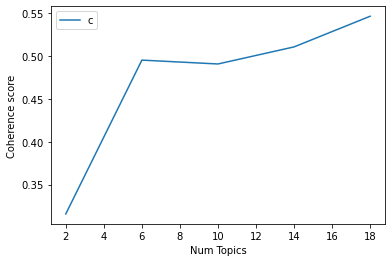

In [22]:
#Using the c_v measure
#model_list, coherence_values = compute_coherence_values(texts=tokenized_texts_fake, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=20; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts_fake, dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

## Find optimal number of topics method 2

This methods takes a very long time, but will also give alpha and beta values

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_texts_fake, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_texts_fake], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [ ]:
import gensim.corpora as corpora
import gensim
PATH_TO_MALLET = '/Users/rosalucassen/Documents/UU/DataMining/mallet-2.0.8/bin/mallet'

# Create Dictionary
id2word = corpora.Dictionary(tokenized_texts_fake)
# Create Corpus
texts = tokenized_texts_fake
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])
 
# Build LDA model
lda = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=7,
                                       chunksize=500,
                                       passes=20,
                                       per_word_topics=True)

In [ ]:
from pprint import pprint
# Print the Keyword in the 10 topics
#pprint(lda_real.print_topics())
doc_lda = lda[corpus]

In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=tokenized_texts_fake, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           chunksize=500,
                                           passes=20,
                                           alpha=a,
                                           eta=b)
    
   
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_texts_fake, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 7
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
#corpus = [dictionary.doc2bow(text) for text in tokenized_texts_real]
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results3.csv', index=False)
    pbar.close()

## Results: Most distinctive words
This gives an extreme output, why?

In [ ]:
results_df = distinctive_words(flat_real, flat_fake)
results_df.sort_values('llr', ascending=False).head(5)